In [2]:
from __future__ import print_function, division
import time, os
import numpy as np
import matplotlib.pyplot as plt
import sys
import networkx as nx
import pandas
import math

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
# Load Snapshot Data
s_to_date = lambda x: pandas.to_datetime(x, format='%m/%d/%Y %H:%M:%S')
snapshots_df = pandas.read_csv('/home/cs231n/data/Field_Snaps_With_warranty.txt', converters={'Event DateTime':s_to_date})
#snapshots_df = pandas.read_csv('Field Snaps - With warranty.txt', converters={'Event DateTime':s_to_date})


In [19]:
selected_snapshots = snapshots_df[['Veh Ref ID','DTC',
 'Event DateTime',
 'Event Type Description',
 'Acc Pedal Position',
 'Ambient Air Temp',
 'Barometric Press',
 'Brake Switch',
 'Bus Utilization',
 'Cat Intake Gas Temp',
 'Cat Outlet Gas Temp',
 'Clutch Switch',
 'Cmd Eng Fuel Press',
 'Cruise Status',
 'Dpf Regen Inhibit Sw',
 'Dpf Thermal Mngmnt',
 'Drvr Demand Torque',
 'Eng Air Flow Rate',
 'Eng Avg Fuel Econ',
 'Eng Coolant Level',
 'Eng Coolant Temp',
 'Eng Demand Torque',
 'Eng DPF Intake Press',
 'Eng Egr Valve Pos',
 'Eng Exhaust Gas Temp',
 'Eng Fuel Del Press',
 'EngFuelTemp1',
 'Engine Speed',
 'Eng Man Abs Pressure',
 'Eng Oil Pressure',
 'EngInjRail1Press',
 'EngIntakeMan1Temp',
 'EngOilTemp1',
 'Eng Percent Torque',
 'EngTurbo1Boost',
 'EngTurbo1Pos',
 'EngTurbo1Speed',
 'Event - All Lamps On Time Hr',
 'Event - Amber Lamp Time Hr',
 'Event - Mil Lamp Time Hr',
 'Event - Red Lamp Time Hr',
 'Exhaust Tank Level',
 'Exhaust Tank Temp',
 'Fan Speed',
 'Keyswitch Bat Pot',
 'Part Trap Diff Press',
 'Part Trap Out Temp',
 'Scr Intake Gas Temp',
 'Scr Outlet Gas Temp',
 'Vehicle Speed',
 'Population',
 'DTCID',
 'Trip Distance',
 'Trip Idle Time',
 'Trip Run Time',
 'Altitude',
 'Engine Start Ambient',
 'Engine Start Coolant',
 'Ignition Cycle Counter',
 'Latitude',
 'Longitude',
 'Lifetime Idle Hours',
 'Lifetime Idle Fuel',
 'Lifetime Fuel',
 'Lifetime Distance',
 'Lifetime Engine Hours']]

In [22]:
#---------------------------------------
# Data-Cleaning - Snapshots (part 1)
#---------------------------------------
# Drop DTC column with 100% unknown values
selected_snapshots = selected_snapshots.drop(['DTC'], axis = 1)  #--> 1581892 x 65

# drop duplicate rows
selected_snapshots = selected_snapshots.drop_duplicates() 
selected_snapshots.shape  #before: 1581892 x 65, after removing duplicate rows: 1015071 x 65

# Checking for null entries
nullTable = selected_snapshots.isnull().sum()
nullTable[nullTable > 0]/len(selected_snapshots)


Eng Avg Fuel Econ         0.001537
Eng DPF Intake Press      0.000031
Eng Fuel Del Press        0.000062
EngInjRail1Press          0.000052
EngIntakeMan1Temp         0.000003
Fan Speed                 0.000003
Ignition Cycle Counter    0.691675
dtype: float64

In [23]:
selected_snapshots.shape

(1015071, 65)

In [24]:
#---------------------------------------
# Data-Cleaning - Snapshots (part 2)
#---------------------------------------
# Remove column 'Ignition Cycle Counter' ~69.2% missing values  --> 101571 x 64
selected_snapshots = selected_snapshots.drop('Ignition Cycle Counter', axis=1) 

# Impute missing values using mean value, i.e. E(value | vehicle id)
fields = ['Eng Avg Fuel Econ', 'Eng DPF Intake Press', 'Eng Fuel Del Press', 'EngInjRail1Press', 'EngIntakeMan1Temp', 'Fan Speed']
for f in fields:
    noData_vehID = selected_snapshots[selected_snapshots[f].isnull()]['Veh Ref ID'].unique()
    for veh_id in noData_vehID:
        # compute mean value of field f for that vehicle
        value = selected_snapshots[selected_snapshots['Veh Ref ID'] ==  veh_id][f].mean()
        
        #update missing value with mean value
        idx = selected_snapshots.index[selected_snapshots[f].isnull()]
        selected_snapshots.loc[idx,f] = value

nullTable = selected_snapshots.isnull().sum()
nullTable[nullTable > 0]/len(selected_snapshots)

Series([], dtype: float64)

In [25]:
#------------------------------------------------------------
# Data Cleaning - Snapshots (part 3)
#------------------------------------------------------------
# Datatype Assignement - selected_snapshot
# Assign correct datatype for categorical variables in selected_snapshots     
category_var = ['Event Type Description','Brake Switch','Clutch Switch','Cruise Status','Dpf Regen Inhibit Sw', 
                'Dpf Thermal Mngmnt','Eng Coolant Level','DTCID']

for i in category_var:
    selected_snapshots[i] = selected_snapshots[i].astype('category')
    
header = list(selected_snapshots.columns.values)
print('Feature:\tDatatype\t#Unique Entries')
for i in header:
    print('%s:\t%s\t%s' % (i, selected_snapshots[i].dtype, len(selected_snapshots[i].unique())))

# Drop dominant column 'Polulation': only 1 unique value ('2') for all snapshots --> 101571 x 63
selected_snapshots.drop('Population', axis=1, inplace=True)

Feature:	Datatype	#Unique Entries
Veh Ref ID:	float64	797
Event DateTime:	datetime64[ns]	956362
Event Type Description:	category	4
Acc Pedal Position:	float64	251
Ambient Air Temp:	float64	696
Barometric Press:	float64	76
Brake Switch:	category	2
Bus Utilization:	float64	83
Cat Intake Gas Temp:	float64	4462
Cat Outlet Gas Temp:	float64	5152
Clutch Switch:	category	2
Cmd Eng Fuel Press:	float64	20405
Cruise Status:	category	2
Dpf Regen Inhibit Sw:	category	3
Dpf Thermal Mngmnt:	category	2
Drvr Demand Torque:	float64	102
Eng Air Flow Rate:	float64	18800
Eng Avg Fuel Econ:	float64	4129
Eng Coolant Level:	category	3
Eng Coolant Temp:	float64	129
Eng Demand Torque:	float64	104
Eng DPF Intake Press:	float64	63
Eng Egr Valve Pos:	float64	1001
Eng Exhaust Gas Temp:	float64	601
Eng Fuel Del Press:	float64	255
EngFuelTemp1:	float64	102
Engine Speed:	float64	6353
Eng Man Abs Pressure:	float64	159
Eng Oil Pressure:	float64	196
EngInjRail1Press:	float64	2472
EngIntakeMan1Temp:	float64	126
EngOilTem

In [26]:
# Load Repairs Data
r_to_date = lambda x: pandas.to_datetime(x, format='%m/%d/%Y')
repairs_df = pandas.read_csv('/home/cs231n/data/repairs.csv', converters={'Rpr_Dt':r_to_date})
#repairs_df = pandas.read_csv('repairs.csv', converters={'Rpr_Dt':r_to_date})

In [27]:
selected_repairs = repairs_df[[
 'Chassis\nReference\nNumber',
 'Model Vehicle',
 'Build_Dt',
 'Dlvry_Dt',
 'In Service Date',
 'Miles',
 'Rpr_Dt',
 'ATA3',
 'ATA3Desc',
 'ATA6',
 'ATA6Desc',
 'ATA9',
 'ATA9Desc',
 'Fail Type',
 'Repair Cost']]
selected_repairs = selected_repairs[selected_repairs['Chassis\nReference\nNumber'].notnull()] 
selected_repairs.shape  #before: 1128x15, after: 853x15

(853, 15)

In [28]:
#---------------------------------------
# Data-Cleaning - selected_repairs
#---------------------------------------
#filter away vehicles that broke down before delivery & service (veh 616: accident during undecking) 
selected_repairs = selected_repairs[selected_repairs['Miles']>0]   
selected_repairs.shape   # before: 853x15, after: 852x15

# identify and remove rows with no snapshot data prior to repair date
nodata_veh_repair = []
for veh_id in selected_repairs['Chassis\nReference\nNumber'].unique():
    v_snapshots = selected_snapshots[selected_snapshots['Veh Ref ID'] == veh_id].sort_values(by='Event DateTime')
    repairDate = (selected_repairs[selected_repairs['Chassis\nReference\nNumber']==veh_id]['Rpr_Dt'])    
    for r in repairDate:
        if len(v_snapshots[v_snapshots['Event DateTime']<=r]) == 0: #no snapshot data prior to repair date
            nodata_veh_repair.append({'Chassis\nReference\nNumber':veh_id,'Rpr_Dt':r})
            #remove that row in selected_repair
            idx = selected_repairs.index[(selected_repairs['Chassis\nReference\nNumber'] == veh_id) & (selected_repairs['Rpr_Dt'] == r)]
            selected_repairs = selected_repairs.drop(idx)
            
nodata_veh_repair = pandas.DataFrame(nodata_veh_repair)
selected_repairs.shape  # before: 852x15, after: 713x15

# check for other null entries:http://35.227.169.231:8000/notebooks/Load_PACCAR_Data_withCleaning.ipynb#
# ('Chasis\nReference\nNumber', 'ATA9', 'Rpr_Dt') has no null entries. Sufficient to link to snapshot data
selected_repairs.isnull().sum()

Chassis\nReference\nNumber    0
Model Vehicle                 0
Build_Dt                      0
Dlvry_Dt                      0
In Service Date               0
Miles                         0
Rpr_Dt                        0
ATA3                          0
ATA3Desc                      0
ATA6                          0
ATA6Desc                      1
ATA9                          0
ATA9Desc                      0
Fail Type                     4
Repair Cost                   0
dtype: int64

In [3]:
# save cleaned data to pickle format for quick reloading in future
#selected_snapshots.to_pickle('cleaned_selected_snapshots.pkl')
#selected_repairs.to_pickle('cleaned_selected_repairs.pkl')

# reload cleaned data
selected_snapshots = pandas.read_pickle('cleaned_selected_snapshots.pkl')
selected_repairs = pandas.read_pickle('cleaned_selected_repairs.pkl')

# Reset indices of loaded dataframes
selected_snapshots = selected_snapshots.reset_index(drop=True)
selected_repairs = selected_repairs.reset_index(drop=True)

In [4]:
def split_test_train(repairs, testfract):
    mask = (repairs['Chassis\nReference\nNumber']==0) #all false
    
    for repairCode in repairs['ATA9'].unique():    
        v_repairs = repairs[repairs['ATA9'] == repairCode]
        idx = v_repairs.index
        #print(repairCode, len(v_repairs))

        if len(v_repairs) > 1:
            # randomly select N cases with matching ATA9 code
            # where N = maxTestCase ~ 20% of #cases with the same ATA9 code
            maxTestCase = math.ceil(testfract*len(v_repairs))
            a = list(range(0,maxTestCase))
            np.random.shuffle(a)
            mask.loc[idx[a[0:maxTestCase]]] = True

    #mask.loc[idx[a[0:maxTestCase]]]
    #test = repairs[mask][['Chassis\nReference\nNumber','Model Vehicle','ATA3','ATA6','ATA9','Repair Cost','Rpr_Dt','snapshot Qty b4 RepairDt']].sort_values('ATA9')
    #train = repairs[~mask][['Chassis\nReference\nNumber','Model Vehicle','ATA3','ATA6','ATA9','Repair Cost','Rpr_Dt','snapshot Qty b4 RepairDt']].sort_values('ATA9')
    test = repairs[mask][['Chassis\nReference\nNumber','Model Vehicle','ATA3','ATA6','ATA9','Repair Cost','Rpr_Dt']].sort_values('ATA9')
    train = repairs[~mask][['Chassis\nReference\nNumber','Model Vehicle','ATA3','ATA6','ATA9','Repair Cost','Rpr_Dt']].sort_values('ATA9')
    
    #print([test, train])
    return [test, train]

In [79]:
#rename repair column 'Chassis\nReference\nNumber' to 'Chassis Reference Number'
#selected_repairs.columns = ['Chassis\nReference\nNumber' if x=='Chassis Reference Number' else x for x in selected_repairs.columns]
#selected_repairs.columns.values

array(['Chassis\nReference\nNumber', 'Model Vehicle', 'Build_Dt',
       'Dlvry_Dt', 'In Service Date', 'Miles', 'Rpr_Dt', 'ATA3',
       'ATA3Desc', 'ATA6', 'ATA6Desc', 'ATA9', 'ATA9Desc', 'Fail Type',
       'Repair Cost'], dtype=object)

In [5]:
# Compile test-val-train sets for each ATA6 code (while ensuring similar ATA9 distribution over test-val-train sets
ata6_test = []
ata6_val = []
ata6_train = []
length = []
for ata6 in selected_repairs['ATA6'].unique():
    #ata6 = 43007
    repairs = selected_repairs[selected_repairs['ATA6']==ata6]
    length.append(len(repairs))
    [test, temp] = split_test_train(repairs, 0.15)
    [val, train] = split_test_train(temp, 0.2)

    if(len(ata6_test) == 0):
        ata6_test = test
    else:
        ata6_test = ata6_test.append(test)

    if(len(ata6_val) == 0):
        ata6_val = val
    else:
        ata6_val = ata6_val.append(val)

    if(len(ata6_train) == 0):
        ata6_train = train
    else:
        ata6_train = ata6_train.append(train)

[len(ata6_test), len(ata6_val), len(ata6_train), sum(length)]
# Out of 1128 repairs: 275 repairs have no 'Chasis Reference Number', 139 repairs have no snapshot data before them, 
# 1 repair was due to an accident during undecking before delivery. The leaves only 713 valid repairs left, which are
# assigned to test (129), validation (120) and train (464)

[129, 120, 464, 713]

In [6]:
#-------------------------------------------------------------
# Define: ok = no repairs with medium, high or very high cost
# Split "ok" vehicles into ok_test, ok_train for inclusion in test and train (if necessary)
#-------------------------------------------------------------
# Get "ok" vehicle IDs
ok_veh_ids = list(set(selected_snapshots['Veh Ref ID'].unique()) - set(ata6_train['Chassis\nReference\nNumber'].unique()) 
                 - set(ata6_val['Chassis\nReference\nNumber'].unique())
                  - set(ata6_test['Chassis\nReference\nNumber'].unique()) )
ok_veh_ids = (np.array(ok_veh_ids))

# Get random permutation of indices of ok_veh_ids
a = pandas.Series(np.random.random(len(ok_veh_ids)))
a = a.sort_values().index

# split ok vehicles into test, val and train with the same proportion as those with ata6_test, ata6_val, ata6_train
total = len(ata6_test)+len(ata6_val)+len(ata6_train)
test_proportion = len(ata6_test)/total
val_proportion = len(ata6_val)/total

maxTestCase = round(len(ok_veh_ids)*test_proportion)
maxValCase = round(len(ok_veh_ids)*val_proportion)
ok_test = ok_veh_ids[a[0:maxTestCase].values]
ok_val = ok_veh_ids[a[maxTestCase:(maxTestCase+maxValCase)].values]
ok_train = ok_veh_ids[a[(maxTestCase+maxValCase):]]

print([len(ok_test),len(ok_val),len(ok_train)])

[43, 40, 156]


In [7]:
#rename repair column 'Chassis\nReference\nNumber' to 'Chassis Reference Number' for train, val and test sets
ata6_test.columns = ['Chassis Reference Number' if x=='Chassis\nReference\nNumber' else x for x in ata6_test.columns]
ata6_val.columns = ['Chassis Reference Number' if x=='Chassis\nReference\nNumber' else x for x in ata6_val.columns]
ata6_train.columns = ['Chassis Reference Number' if x=='Chassis\nReference\nNumber' else x for x in ata6_train.columns]

# Output veh_IDs in test, validation and train sets to csv
ata6_test.to_csv('ATA6_test.csv')
ata6_val.to_csv('ATA6_val.csv')
ata6_train.to_csv('ATA6_train.csv')

pandas.DataFrame(ok_test).to_csv('ATA6_ok_test.csv')
pandas.DataFrame(ok_val).to_csv('ATA6_ok_val.csv')
pandas.DataFrame(ok_train).to_csv('ATA6_ok_train.csv')

In [8]:
def plotHistogram(data, group_key, selected_groups, xlabel, ylabel, title, filename):
    bars = []
    heights = []
    for key, group in data.groupby(group_key):
        if key in selected_groups:
            bars.append(key)
            heights.append(len(group))
    numbars = len(bars)
    # range(numbars) in following command yields [0,1,...,numbars-1]
    plt.xticks(range(numbars), bars, rotation='vertical')
    plt.bar(range(numbars), heights, align='center',color='skyblue')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.savefig(filename)

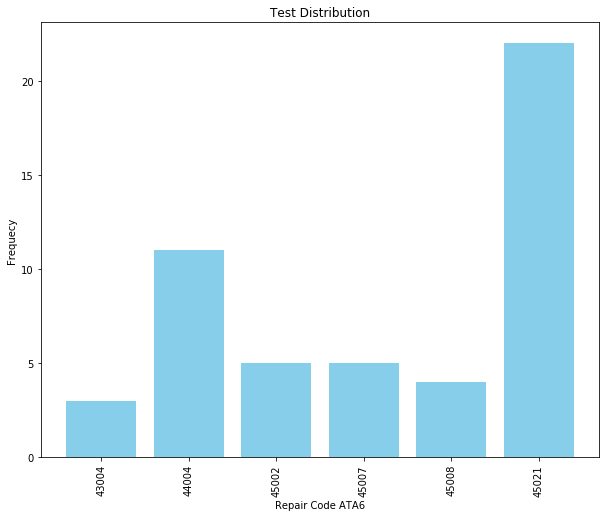

In [85]:
# Plot Test Distribution
selected_ata6 = [45021, 44004, 43004, 45008, 45002, 45007]
data = ata6_test
code = 'ATA6'
xlabel = 'Repair Code ' + code
ylabel = 'Frequecy'
title = 'Test Distribution'
filename = 'Test_'+code+'.png'
plotHistogram(data, code, selected_ata6, xlabel, ylabel, title, filename)

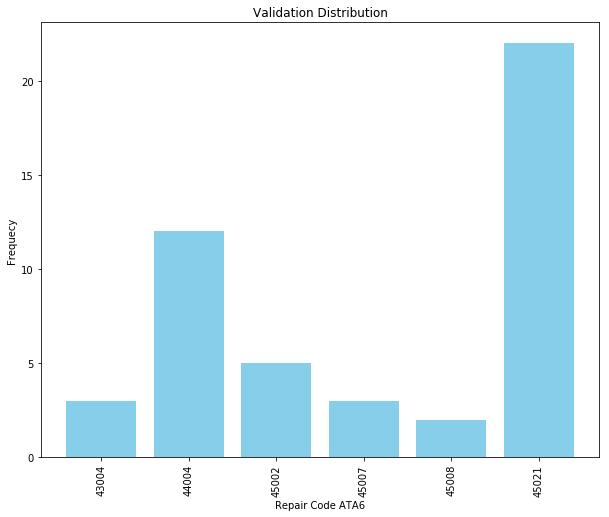

In [39]:
# Plot Validation Distribution
selected_ata6 = [45021, 44004, 43004, 45008, 45002, 45007]
data = ata6_val
code = 'ATA6'
xlabel = 'Repair Code ' + code
ylabel = 'Frequecy'
title = 'Validation Distribution'
filename = 'Val_'+code+'.png'
plotHistogram(data, code, selected_ata6, xlabel, ylabel, title, filename)

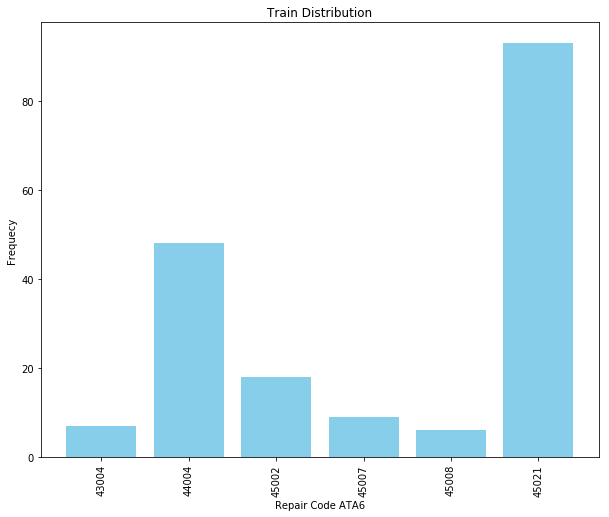

In [47]:
# Plot Train Distribution
selected_ata6 = [45021, 44004, 43004, 45008, 45002, 45007]
data = ata6_train
code = 'ATA6'
xlabel = 'Repair Code ' + code
ylabel = 'Frequecy'
title = 'Train Distribution'
filename = 'Train_'+code+'.png'
plotHistogram(data, code, selected_ata6, xlabel, ylabel, title, filename)

In [48]:
# List down repair codes ATA6 that are in training set but not shown
selected_ata6 = [45021, 44004, 43004, 45008, 45002, 45007]
extra = []
for repair_type, repair_group in ata6_train.groupby('ATA6'):
    if ~(repair_type in selected_ata6):
        extra.append({code:repair_type, 'Count':sum(repair_group['ATA6']==repair_type)})
pandas.DataFrame(extra)

,ATA6,Count
0,3001,1
1,13009,3
2,32002,1
3,41004,2
4,42003,1
5,42004,32
6,42005,1
7,42006,1
8,43001,27
9,43002,5


In [86]:
# Compute Priors:
# - p(Fail = 1) = 0.45 (% of snapshots that lead to a repair), P(Fail = 0) = 0.55
# - assign special code ATA6=0 to represent no failure/repair --> so, P(ATA6 = 0 | Fail = 0) = 1, = 0 for other ATA6  
# - P(ATA6 | Fail = 1) = % of repairs with code ATA6
# - pc_vec = P(ATA6) = P(ATA6 | Fail = 1)*P(Fail = 1) + P(ATA6 | Fail = 0)*P(Fail = 0)                                           
# ---------------------                
selected_ata6 = [45021, 44004, 43004, 45008, 45002, 45007]
#selected_repairs = pandas.read_pickle('cleaned_selected_repairs.pkl')
prior_ata6 = selected_repairs.groupby('ATA6').size().reset_index(name='count')
total_repairs = len(selected_repairs)
prior_ata6['prob'] = prior_ata6['count']/float(total_repairs)
#prior_ata6
pc_vec = prior_ata6[prior_ata6['ATA6'].isin(selected_ata6)]
pc_vec = pc_vec[['ATA6','prob']]
pc_vec = np.array(pc_vec)

# normalize
den = pc_vec[:,1].sum()
pc_vec[:,1] /= den
print(pc_vec[:,1])

# multiply pc_vec by P(F=1)
pc_vec[:,1] *= 0.45
print(pc_vec[:,1])

#pc_vec.concat([0, 0.55])
pc_vec = np.vstack([[0, 0.55], pc_vec])
print(pc_vec[:,1].sum())

#pc_vec = pc_vec.concat(pandas.DataFrame({'ATA6': 0, 'prob':0.65}))

#d = {'ATA6': 0, 'prob':0.65}
#row = pandas.DataFrame(data = d)

pc_vec = pandas.DataFrame(pc_vec,columns=['ATA6', 'prob'])
pc_vec.to_pickle('pc_vec.pkl')
pc_vec

[ 0.04676259  0.25539568  0.10071942  0.06115108  0.04316547  0.49280576]
[ 0.02104317  0.11492806  0.04532374  0.02751799  0.01942446  0.22176259]
1.0


,ATA6,prob
0,0.0,0.550000
1,43004.0,0.021043
2,44004.0,0.114928
3,45002.0,0.045324
4,45007.0,0.027518
5,45008.0,0.019424
6,45021.0,0.221763


In [87]:
# Compile conditional probability distributions
cost = ['very low', 'low', 'medium', 'high ', 'very high']
ATA6_code = selected_repairs['ATA6'].unique()

# P(Repair Cost | ATA6)
cost_given_ata6 = []
for ata6 in ATA6_code:
    base = sum((selected_repairs['ATA6']==ata6))
    for c in cost:
        count = sum((selected_repairs['ATA6']==ata6) & (selected_repairs['Repair Cost']==c))
        cost_given_ata6.append({'ATA6':ata6, 'cost':c,'count':count, 'prob':float(count)/base})
    cost_given_ata6.append({'ATA6':ata6, 'cost':'subtotal','count':base, 'prob':float(base)/base})

# P(ATA6 | Repair Cost)
ata6_given_cost = []
for c in cost:
    base = sum((selected_repairs['Repair Cost']==c))
    for ata6 in ATA6_code:    
        count = sum((selected_repairs['ATA6']==ata6) & (selected_repairs['Repair Cost']==c))
        ata6_given_cost.append({'cost':c, 'ATA6':ata6, 'count':count,'prob':float(count)/base})
    ata6_given_cost.append({'cost':c,'ATA6':'subtotal', 'count':base, 'prob':float(base)/base})

cost_given_ata6 = pandas.DataFrame(cost_given_ata6)
ata6_given_cost = pandas.DataFrame(ata6_given_cost)
ata6_given_cost.to_csv('prob_ata6_given_cost.csv')
cost_given_ata6.to_csv('prob_cost_given_ata6.csv')

In [88]:
# Compile conditional probability distributions
cost = ['very low', 'low', 'medium', 'high ', 'very high']
ATA3_code = selected_repairs['ATA3'].unique()

# P(Repair Cost | ATA6)
cost_given_ata3 = []
for ata3 in ATA3_code:
    base = sum((selected_repairs['ATA3']==ata3))
    for c in cost:
        count = sum((selected_repairs['ATA3']==ata3) & (selected_repairs['Repair Cost']==c))
        cost_given_ata3.append({'ATA3':ata3, 'cost':c,'count':count, 'prob':float(count)/base})
    cost_given_ata3.append({'ATA3':ata3, 'cost':'subtotal','count':base, 'prob':float(base)/base})

# P(ATA6 | Repair Cost)
ata3_given_cost = []
for c in cost:
    base = sum((selected_repairs['Repair Cost']==c))
    for ata3 in ATA3_code:    
        count = sum((selected_repairs['ATA3']==ata3) & (selected_repairs['Repair Cost']==c))
        ata3_given_cost.append({'cost':c, 'ATA3':ata3, 'count':count,'prob':float(count)/base})
    ata3_given_cost.append({'cost':c,'ATA3':'subtotal', 'count':base, 'prob':float(base)/base})

cost_given_ata3 = pandas.DataFrame(cost_given_ata3)
ata3_given_cost = pandas.DataFrame(ata3_given_cost)
ata3_given_cost.to_csv('prob_ata3_given_cost.csv')
cost_given_ata3.to_csv('prob_cost_given_ata3.csv')

In [13]:
# Compile conditional probability distributions
cost = ['very low', 'low', 'medium', 'high ', 'very high']
ATA9_code = selected_repairs['ATA9'].unique()

# P(Repair Cost | ATA6)
cost_given_ata9 = []
for ata9 in ATA9_code:
    base = sum((selected_repairs['ATA9']==ata9))
    for c in cost:
        count = sum((selected_repairs['ATA9']==ata9) & (selected_repairs['Repair Cost']==c))
        cost_given_ata9.append({'ATA9':ata9, 'cost':c,'count':count, 'prob':float(count)/base})
    cost_given_ata9.append({'ATA9':ata9, 'cost':'subtotal','count':base, 'prob':float(base)/base})

# P(ATA6 | Repair Cost)
ata9_given_cost = []
for c in cost:
    base = sum((selected_repairs['Repair Cost']==c))
    for ata9 in ATA9_code:    
        count = sum((selected_repairs['ATA9']==ata9) & (selected_repairs['Repair Cost']==c))
        ata9_given_cost.append({'cost':c, 'ATA9':ata9, 'count':count,'prob':float(count)/base})
    ata9_given_cost.append({'cost':c,'ATA9':'subtotal', 'count':base, 'prob':float(base)/base})

cost_given_ata9 = pandas.DataFrame(cost_given_ata9)
ata9_given_cost = pandas.DataFrame(ata9_given_cost)
ata9_given_cost.to_csv('prob_ata9_given_cost.csv')
cost_given_ata9.to_csv('prob_cost_given_ata9.csv')

In [14]:
# bar chart function
def barchart(group,key_X,key_Y,xlabel,ylabel,title,filename):
    bars = []
    heights = []
    bars = group[key_X]
    heights = group[key_Y]
    numbars = len(bars)
    plt.xticks(range(numbars), bars, rotation='vertical')
    plt.bar(range(numbars), heights, align='center',color='skyblue')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    #plt.show()
    plt.savefig(filename)

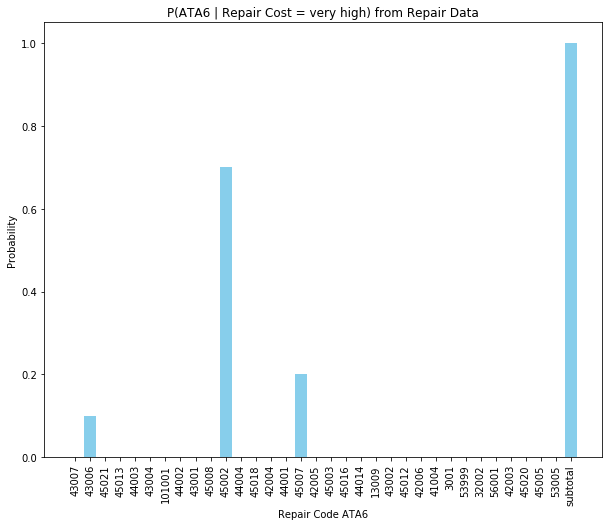

In [89]:
c = 'very high'
group = ata6_given_cost[(ata6_given_cost['cost'] == c)]
key_X = 'ATA6'
key_Y = 'prob'
xlabel = 'Repair Code ATA6'
ylabel = 'Probability'
title = 'P(ATA6 | Repair Cost = ' + c + ') from Repair Data'
filename = 'Prob_ATA6_given_Cost_'+c+'.png'
barchart(group,key_X,key_Y,xlabel,ylabel,title,filename)

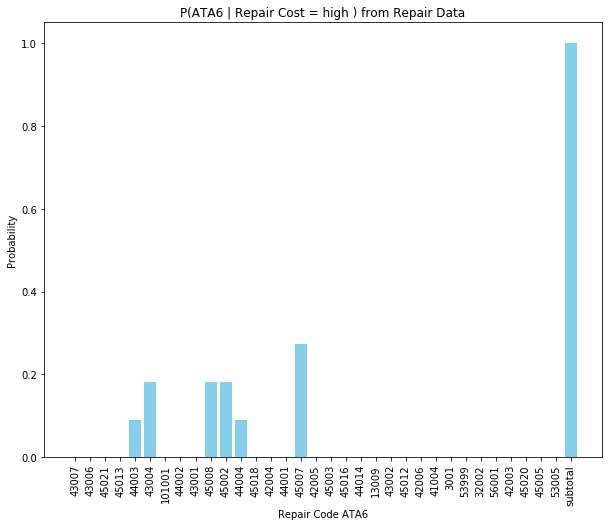

In [16]:
c = 'high '
group = ata6_given_cost[(ata6_given_cost['cost'] == c)]
key_X = 'ATA6'
key_Y = 'prob'
xlabel = 'Repair Code ATA6'
ylabel = 'Probability'
title = 'P(ATA6 | Repair Cost = ' + c + ') from Repair Data'
filename = 'Prob_ATA6_given_Cost_'+c+'.png'
barchart(group,key_X,key_Y,xlabel,ylabel,title,filename)

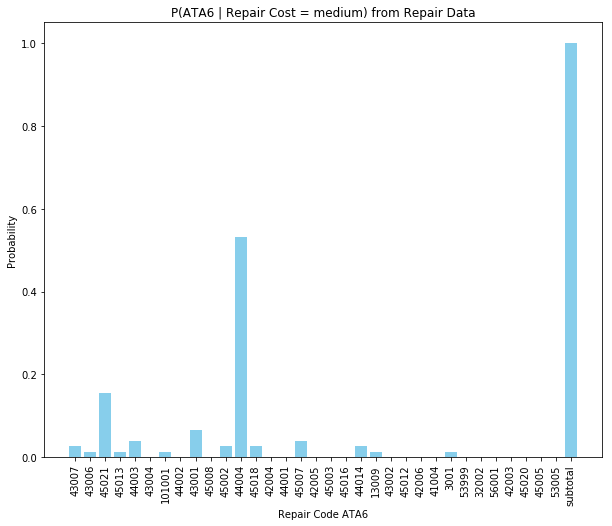

In [17]:
c = 'medium'
group = ata6_given_cost[(ata6_given_cost['cost'] == c)]
key_X = 'ATA6'
key_Y = 'prob'
xlabel = 'Repair Code ATA6'
ylabel = 'Probability'
title = 'P(ATA6 | Repair Cost = ' + c + ') from Repair Data'
filename = 'Prob_ATA6_given_Cost_'+c+'.png'
barchart(group,key_X,key_Y,xlabel,ylabel,title,filename)

In [18]:
# Select ATA6 associated with higher cost repairs to predict
selected_ata6 = []
threshold = 0.1
for c in ['medium', 'high ', 'very high']:
    data = ata6_given_cost[(ata6_given_cost['cost'] == c)]
    data = data[(data['ATA6'] != 'subtotal') & (data['prob'] > threshold)]
    if len(selected_ata6) == 0:
        selected_ata6 = data[['ATA6','cost','count','prob']]
    else:
        selected_ata6 = selected_ata6.append(data[['ATA6','cost','count','prob']])

print('Selected ATA6 with P(ATA6 | cost) > 0.1:')
print(selected_ata6['ATA6'].unique() )
selected_ata6

Selected ATA6 with P(ATA6 | cost) > 0.1:
[45021 44004 43004 45008 45002 45007]


,ATA6,cost,count,prob
70,45021,medium,12,0.155844
79,44004,medium,41,0.532468
107,43004,high,2,0.181818
111,45008,high,2,0.181818
112,45002,high,2,0.181818
117,45007,high,3,0.272727
146,45002,very high,7,0.700000
151,45007,very high,2,0.200000


In [90]:
# Example to get cost probability aray P(cost | ATA6) for all ATA6 and all repair costs
repair_costs = ['very low', 'low', 'medium', 'high ', 'very high']
selected_ata6 = [45021, 44004, 43004, 45008, 45002, 45007]
selected_ata6 = list(np.sort(selected_ata6))

cost_prob_array = []
for c in repair_costs:
    group = cost_given_ata6[(cost_given_ata6['cost'] == c) & (cost_given_ata6['ATA6'].isin(selected_ata6))]
    
    try:
        # needed if reading in cost_give_ata6 directly from csv (which adds this extra column)
        group = group.drop(['Unnamed: 0'],1)
    except:
        pass
    
    group = group.sort_values(by=['ATA6'])
    print(group[['ATA6','prob']])
    cost_prob_array.append(np.array(group['prob']))

# adding in new column P(cost | ATA6 = 0) = 0 for cost = [very low, low, medium, high, very high]
cost_prob_array = np.array(cost_prob_array)
z = np.zeros((5,1), dtype=float)

# adding in new row for P(cost = 0 | ATA6) = 1 if ATA6 = 0, = 0 if ATA6 > 0
a = np.zeros((1,7), dtype=float)
a[0,0]=1
#print(a)

#print(cost_prob_array)
cost_prob_array = np.append(z, cost_prob_array, axis=1)
cost_prob_array = np.append(a, cost_prob_array, axis=0)
#print(cost_prob_array.sum(axis=0))
np.savetxt("cost_prob.csv", cost_prob_array, delimiter=",")

# view final cost_prob_array
pandas.DataFrame(cost_prob_array,columns = np.append(0,selected_ata6))

     ATA6      prob
30  43004  0.461538
66  44004  0.084507
60  45002  0.464286
90  45007  0.470588
54  45008  0.416667
12  45021  0.890511
     ATA6      prob
31  43004  0.384615
67  44004  0.323944
61  45002  0.142857
91  45007  0.058824
55  45008  0.416667
13  45021  0.021898
     ATA6      prob
32  43004  0.000000
68  44004  0.577465
62  45002  0.071429
92  45007  0.176471
56  45008  0.000000
14  45021  0.087591
     ATA6      prob
33  43004  0.153846
69  44004  0.014085
63  45002  0.071429
93  45007  0.176471
57  45008  0.166667
15  45021  0.000000
     ATA6      prob
34  43004  0.000000
70  44004  0.000000
64  45002  0.250000
94  45007  0.117647
58  45008  0.000000
16  45021  0.000000


,0,43004,44004,45002,45007,45008,45021
0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.0,0.461538,0.084507,0.464286,0.470588,0.416667,0.890511
2,0.0,0.384615,0.323944,0.142857,0.058824,0.416667,0.021898
3,0.0,0.000000,0.577465,0.071429,0.176471,0.000000,0.087591
4,0.0,0.153846,0.014085,0.071429,0.176471,0.166667,0.000000
5,0.0,0.000000,0.000000,0.250000,0.117647,0.000000,0.000000


In [94]:
selected_ata6 = [45021, 44004, 43004, 45008, 45002, 45007]
selected_ata6 = list(np.sort(selected_ata6))
total=0
total_mhvh = 0
for ata6 in selected_ata6:
    data = cost_given_ata6[cost_given_ata6['ATA6'] == int(ata6)]
    total = total + float(data[data['cost']=='subtotal']['count'].values)
    for cost in ['medium', 'high ', 'very high']:
        total_mhvh = total_mhvh + float(data[data['cost']==cost]['count'].values)
    print(data)
    print('\n')
print('total # repairs with selected_ATA6 = ' + str(total))
print('total_# med, high, v. high repairs with selected_ATA6 = ' + str(total_mhvh))

     ATA6       cost  count      prob
30  43004   very low      6  0.461538
31  43004        low      5  0.384615
32  43004     medium      0  0.000000
33  43004      high       2  0.153846
34  43004  very high      0  0.000000
35  43004   subtotal     13  1.000000


     ATA6       cost  count      prob
66  44004   very low      6  0.084507
67  44004        low     23  0.323944
68  44004     medium     41  0.577465
69  44004      high       1  0.014085
70  44004  very high      0  0.000000
71  44004   subtotal     71  1.000000


     ATA6       cost  count      prob
60  45002   very low     13  0.464286
61  45002        low      4  0.142857
62  45002     medium      2  0.071429
63  45002      high       2  0.071429
64  45002  very high      7  0.250000
65  45002   subtotal     28  1.000000


     ATA6       cost  count      prob
90  45007   very low      8  0.470588
91  45007        low      1  0.058824
92  45007     medium      3  0.176471
93  45007      high       3  0.176471
94  45

In [9]:
def get_snapshot_count(selected_codes, repairs, snapshots):
    
    s_veh_key = 'Veh Ref ID'
    r_veh_key = 'Chassis Reference Number'
    s_time_key = 'Event DateTime'
    r_time_key = 'Rpr_Dt'
    code = 'ATA6'
    
    snapshot_table = []
    total_snapshots = []
    
    # Must sort repair by their repair date so that after groupby('Chassis Reference Number')
    # repairs are accessed in order of increasing repair date.
    # This ensures start and end are set in the right order to calculate #snapshots correctly
    repairs = repairs.sort_values(by = r_time_key)
    
    start_date = pandas.to_datetime('1/1/2000')

    for ata6 in selected_codes:
        if ata6 == 0:
            continue        

        repair_group = repairs[(repairs[code] == ata6)].groupby(by=r_veh_key)
        for veh_id, row in repair_group:
            v_snapshots = snapshots[snapshots[s_veh_key] == veh_id].sort_values(by=s_time_key)
            start = start_date
            num_snapshots = 0
            num_repairs = 0
            for end in row[r_time_key]:
                range_mask = (v_snapshots[s_time_key] >= start) & (v_snapshots[s_time_key] <= end)
                num_snapshots = sum(range_mask)
                num_repairs += 1
                start = end
                snapshot_table.append({code:ata6, r_veh_key: veh_id, r_time_key:end, 'Num_Snapshots':num_snapshots})

    for ata6, row in pandas.DataFrame(snapshot_table).groupby(code):
        total_snapshots.append({code:ata6,'Total_Snapshots':row['Num_Snapshots'].sum()})
    
    snapshot_table = pandas.DataFrame(snapshot_table)
    total_snapshots = pandas.DataFrame(total_snapshots)
    
    return (snapshot_table, total_snapshots)

In [10]:
# Getting snapshot counts
selected_codes = [0,45021, 44004, 43004, 45008, 45002, 45007] # first code is the ok
selected_codes = list(np.sort(selected_codes))

(ata6_train_snapshot_breakdown, ata6_train_snapshot_total) = get_snapshot_count(selected_codes, ata6_train, selected_snapshots)
(ata6_val_snapshot_breakdown, ata6_val_snapshot_total) = get_snapshot_count(selected_codes, ata6_val, selected_snapshots)
(ata6_test_snapshot_breakdown, ata6_test_snapshot_total) = get_snapshot_count(selected_codes, ata6_test, selected_snapshots)

#ata6_train_snapshot_breakdown.to_pickle('ata6_train_snapshot_breakdown.pkl')
#ata6_val_snapshot_breakdown.to_pickle('ata6_val_snapshot_breakdown.pkl')
#ata6_test_snapshot_breakdown.to_pickle('ata6_test_snapshot_breakdown.pkl')
#ata6_train_snapshot_total.to_pickle('ata6_test_snapshot_total.pkl')
#ata6_val_snapshot_total.to_pickle('ata6_val_snapshot_total.pkl')
#ata6_test_snapshot_total.to_pickle('ata6_test_snapshot_total.pkl')

In [97]:
ata6_test_snapshot_total

,ATA6,Total_Snapshots
0,43004,408
1,44004,1906
2,45002,619
3,45007,2946
4,45008,2787
5,45021,3033


In [98]:
ata6_val_snapshot_total

,ATA6,Total_Snapshots
0,43004,2516
1,44004,6413
2,45002,4372
3,45007,688
4,45008,1140
5,45021,11862


In [99]:
ata6_train_snapshot_total

,ATA6,Total_Snapshots
0,43004,6104
1,44004,23627
2,45002,8078
3,45007,6890
4,45008,2399
5,45021,55452


In [18]:
ata6_val_snapshot_breakdown

,ATA6,Chassis Reference Number,Num_Snapshots,Rpr_Dt
0,43004,251.0,395,2016-05-18
1,43004,293.0,34,2016-04-15
2,43004,557.0,2087,2016-06-15
3,44004,84.0,43,2016-05-23
4,44004,113.0,6,2016-05-24
5,44004,211.0,6,2016-05-26
6,44004,362.0,4,2016-05-19
7,44004,424.0,822,2016-06-23
8,44004,493.0,592,2016-07-20
9,44004,515.0,2956,2016-07-21


In [101]:
ata6_val_snapshot_breakdown

,ATA6,Chassis Reference Number,Num_Snapshots,Rpr_Dt
0,43004,251.0,395,2016-05-18
1,43004,293.0,34,2016-04-15
2,43004,557.0,2087,2016-06-15
3,44004,84.0,43,2016-05-23
4,44004,113.0,6,2016-05-24
5,44004,211.0,6,2016-05-26
6,44004,362.0,4,2016-05-19
7,44004,424.0,822,2016-06-23
8,44004,493.0,592,2016-07-20
9,44004,515.0,2956,2016-07-21


In [17]:
selected_ata6 = [45021, 44004, 43004, 45008, 45002, 45007]
data = ata6_val_snapshot_breakdown
temp = data[data['ATA6'].isin(selected_ata6)]['Num_Snapshots'].sort_values()
print('Percentile: #Snapshots b4 Repair Date')
for i in range(10,110,10):
    sorted_index = round(i * len(temp)/100)    
    print('%d: %d' % (i,max(temp[0:sorted_index].values)))
    
win_size = 100
print('total # repairs = %d' % len(temp))
print('# repairs with < %d snapshots = %d' % (win_size, sum(temp < win_size)))
print('# repairs with >= %d snapshots = %d' % (win_size, sum(temp >= win_size)))

Percentile: #Snapshots b4 Repair Date
10: 32
20: 38
30: 56
40: 123
50: 337
60: 395
70: 592
80: 822
90: 1379
100: 3363
total # repairs = 47
# repairs with < 100 snapshots = 18
# repairs with >= 100 snapshots = 29


In [20]:
len(selected_snapshots['EngInjRail1Press'].unique())

2472